In [1]:
import sys

sys.path.append("../src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.linalg import eigh
import sto_ng
import sto_ng_overlap_function
import h5py
import gaussian_overlap_function


importlib.reload(sto_ng)
importlib.reload(sto_ng_overlap_function)
importlib.reload(gaussian_overlap_function)
from sto_ng import *
from sto_ng_overlap_function import *
from gaussian_overlap_function import *

In [3]:
with h5py.File("sto_ng.h5", "r") as f:
    alphas = f["1s/sto-3g/alpha"][:]
    cs = f["1s/sto-3g/c"][:]
alphas = np.array(alphas)
cs = np.array(cs)
cs_new = cs * (2 * alphas / np.pi) ** (3 / 4)

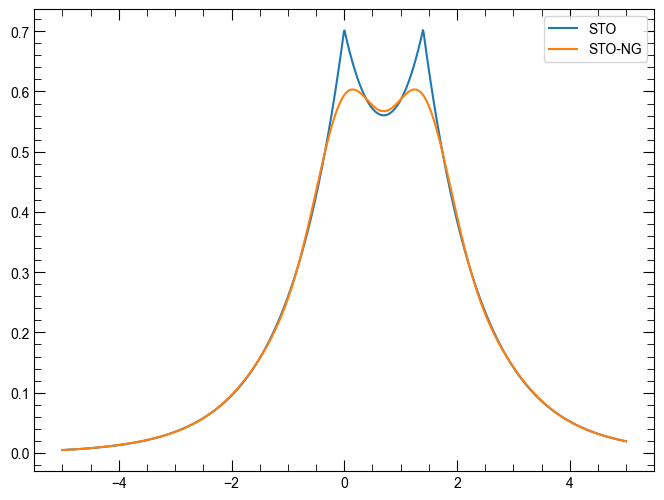

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
x = np.linspace(-5, 5, 1000)


def chi_sto(x, R):
    return (1 / np.pi) ** (1 / 2) * np.exp(-np.abs(x - R))


def chi_sto_ng(x, R):
    return np.sum(cs_new * np.exp(-alphas * (x[:, None] - R) ** 2), axis=1)


ax.plot(x, chi_sto(x, 0) + chi_sto(x, 1.4), label="STO")
ax.plot(x, chi_sto_ng(x, 0) + chi_sto_ng(x, 1.4), label="STO-NG")
ax.legend()

In [5]:
def get_smat(cs, alphas, Rs):
    s_mat = np.zeros((2, 2))
    for i in range(2):
        for j in range(2):
            s_mat[i, j] = Sto3g.norm(cs, alphas, alphas, Rs[i], Rs[j])
    return s_mat

In [6]:
def get_kinetic_mat(cs, alphas, Rs):
    kinetic_mat = np.zeros((2, 2))
    for i in range(2):
        for j in range(2):
            kinetic_mat[i, j] = Sto3g.kinetic(cs, alphas, alphas, Rs[i], Rs[j])
    return kinetic_mat


def get_kinetic_energy(cs, alphas, Rs):
    kinetic_mat = get_kinetic_mat(cs, alphas, Rs)
    s_mat = get_smat(cs, alphas, Rs)
    c_sto_3g = np.array([1, 1])
    kinetic_energy = c_sto_3g @ kinetic_mat @ c_sto_3g / (c_sto_3g @ s_mat @ c_sto_3g)
    return kinetic_energy


def get_potential_mat_0(cs, alphas, Rs):
    potential_mat = np.zeros((2, 2))
    for i in range(2):
        for j in range(2):
            potential_mat[i, j] = Sto3g.potential(
                cs, alphas, alphas, Rs[i], Rs[j], Rs[0]
            )
    return potential_mat


def get_potential_mat_1(cs, alphas, Rs):
    potential_mat = np.zeros((2, 2))
    for i in range(2):
        for j in range(2):
            potential_mat[i, j] = Sto3g.potential(
                cs, alphas, alphas, Rs[i], Rs[j], Rs[1]
            )
    return potential_mat


def get_potential_mat(cs, alphas, Rs):
    return get_potential_mat_0(cs, alphas, Rs) + get_potential_mat_1(cs, alphas, Rs)


def get_potential_energy(cs, alphas, Rs):
    potential_mat = get_potential_mat(cs, alphas, Rs)
    s_mat = get_smat(cs, alphas, Rs)
    c_sto_3g = np.array([1 / np.sqrt(2), 1 / np.sqrt(2)])
    potential_energy = (
        c_sto_3g @ potential_mat @ c_sto_3g / (c_sto_3g @ s_mat @ c_sto_3g)
    )
    return potential_energy


def get_energy_1e(cs, alphas, Rs):
    return 2 * get_potential_energy(cs, alphas, Rs) + 2 * get_kinetic_energy(
        cs, alphas, Rs
    )

In [7]:
def get_ee_coulomb_mat(cs, alphas, Rs):
    ee_coulomb_mat = np.zeros((2, 2, 2, 2))
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    ee_coulomb_mat[i, j, k, l] = Sto3g.ee_coulomb(
                        cs, alphas, alphas, alphas, alphas, Rs[i], Rs[j], Rs[k], Rs[l]
                    )
    return ee_coulomb_mat


def get_energy_2e(cs, alphas, Rs):
    c_sto_3g = np.array([1 / np.sqrt(2), 1 / np.sqrt(2)])
    ee_coulomb_mat = get_ee_coulomb_mat(cs, alphas, Rs)
    s_mat = get_smat(cs, alphas, Rs)
    return (((c_sto_3g @ (c_sto_3g @ ee_coulomb_mat)) @ c_sto_3g) @ c_sto_3g) / (
        c_sto_3g @ s_mat @ c_sto_3g
    ) ** 2


def get_total_energy(zeta, cs, alphas, Rs):
    scaled_alphas = alphas * zeta**2
    return (
        get_energy_1e(cs, scaled_alphas, Rs)
        + get_energy_2e(cs, scaled_alphas, Rs)
        + 1 / np.linalg.norm(Rs[1] - Rs[0])
    )

In [8]:
zeta = 1.24
Rs = [np.array([0, 0, 0]), np.array([1.4, 0, 0])]
kinetic_mat = get_kinetic_mat(cs, zeta**2 * alphas, Rs)
s_mat = get_smat(cs, zeta**2 * alphas, Rs)
c_sto_ng = np.array((1, 1))

In [9]:
def get_kinetic_energy(zeta, cs, alphas, Rs):
    kinetic_mat = get_kinetic_mat(cs, zeta**2 * alphas, Rs)
    s_mat = get_smat(cs, zeta**2 * alphas, Rs)
    c_sto_ng = np.array((1, 1))
    return (c_sto_ng @ kinetic_mat @ c_sto_ng) / (c_sto_ng @ s_mat @ c_sto_ng)


def get_potential_energy(zeta, cs, alphas, Rs):
    potential_mat = get_potential_mat(cs, zeta**2 * alphas, Rs)
    s_mat = get_smat(cs, zeta**2 * alphas, Rs)
    c_sto_ng = np.array((1, 1))
    return c_sto_ng @ potential_mat @ c_sto_ng / (c_sto_ng @ s_mat @ c_sto_ng)


def get_ee_coulomb_energy(zeta, cs, alphas, Rs):
    c_sto_ng = np.array((1, 1))
    ee_coulomb_mat = get_ee_coulomb_mat(cs, zeta**2 * alphas, Rs)
    s_mat = get_smat(cs, zeta**2 * alphas, Rs)
    return (((c_sto_ng @ (c_sto_ng @ ee_coulomb_mat)) @ c_sto_ng) @ c_sto_ng) / (
        c_sto_ng @ s_mat @ c_sto_ng
    ) ** 2


def get_total_energy(zeta, cs, alphas, Rs):
    return (
        2 * get_kinetic_energy(zeta, cs, alphas, Rs)
        + 2 * get_potential_energy(zeta, cs, alphas, Rs)
        + get_ee_coulomb_energy(zeta, cs, alphas, Rs)
        + 1 / np.linalg.norm(Rs[1] - Rs[0])
    )


Rs = [np.array([0, 0, 0]), np.array([1.4, 0, 0])]
get_total_energy(1.24, cs, alphas, Rs)

-1.0183843270130644

In [10]:
# def get_total_energy(zeta, cs, alphas, Rs):
#    kinetic_mat = get_kinetic_mat(cs, zeta**2 * alphas, Rs)
#    potential_mat_0 = get_potential_mat_0(cs, zeta**2 * alphas, Rs)
#    potential_mat_1 = get_potential_mat_1(cs, zeta**2 * alphas, Rs)
#    energy_core = kinetic_mat + potential_mat_0 + potential_mat_1
#    s_mat = get_smat(cs, zeta**2 * alphas, Rs)
#    c_sto_ng = np.array((1, 1))
#    (c_sto_ng @ energy_core @ c_sto_ng) / (c_sto_ng @ s_mat @ c_sto_ng)
#    ee_coulomb_mat = get_ee_coulomb_mat(cs, zeta**2 * alphas, Rs)
#    e1 = (c_sto_ng @ energy_core @ c_sto_ng) / (c_sto_ng @ s_mat @ c_sto_ng)
#    ee = (
#        c_sto_ng
#        @ (c_sto_ng @ ee_coulomb_mat @ c_sto_ng)
#        @ c_sto_ng
#        / (c_sto_ng @ s_mat @ c_sto_ng) ** 2
#    )
#    return 2 * e1 + ee + 1 / np.linalg.norm(Rs[1] - Rs[0])


rs = np.linspace(0.5, 6, 100)
Rs = [np.array([[0, 0, 0], [0, 0, r]]) for r in rs]
total_energies = [get_total_energy(1.24, cs_new, alphas, R) for R in Rs]
kintic_energies = [get_kinetic_energy(1.24, cs_new, alphas, R) for R in Rs]
potential_energies = [get_potential_energy(1.24, cs_new, alphas, R) for R in Rs]
ee_coulomb_energies = [get_ee_coulomb_energy(1.24, cs_new, alphas, R) for R in Rs]

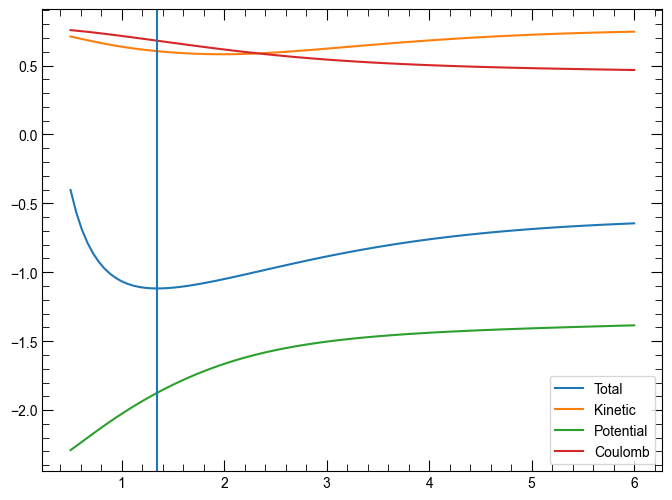

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(rs, total_energies, label="Total")
ax.plot(rs, kintic_energies, label="Kinetic")
ax.plot(rs, potential_energies, label="Potential")
ax.plot(rs, ee_coulomb_energies, label="Coulomb")
ax.axvline(1.346)
ax.legend()

In [12]:
get_total_energy(1.24, cs_new, alphas, np.array([[0, 0, 0], [0, 0, 1.4]]))

-1.1167196202810983

In [13]:
minimize(
    lambda x: get_total_energy(x, cs_new, alphas, np.array([[0, 0, 0], [1.4, 0, 0]])),
    1.24,
    method="Nelder-Mead",
)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -1.1192240563119893
             x: [ 1.190e+00]
           nit: 12
          nfev: 24
 final_simplex: (array([[ 1.190e+00],
                       [ 1.190e+00]]), array([-1.119e+00, -1.119e+00]))

In [14]:
def get_total_energy_r(x, zeta, cs, alphas):
    # x はスカラーとして扱われ、それを使って位置ベクトルを作成
    Rs = np.array([[0, 0, 0], [x[0], 0, 0]])
    return get_total_energy(zeta, cs, alphas, Rs)


def func_to_minimize(vars, *args):
    x, zeta = vars
    return get_total_energy(x, zeta, *args)